<div style="line-height:1.2;">

<h1 style="color:#FF7C00; margin-bottom: 1em;">Transfer Learning with TensorFlow</h1>

<div style="line-height:1.4; margin-top: 0.5em; margin-bottom: 1em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3>
    drive.mount Colab + TensorFlow Hub + ImageDataGenerator + TensorBoard callbacks + Residual Networks + plt.ylim()
</div>

</div>


<div style="line-height:0.5">
<h1 style="color:#FF7C00  "> Transfer Learning with TensorFlow </h1>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>  
    drive.mount Colab + TensorFlow Hub + ImageDataGenerator + TensorBoard callbacks + Residual Networks + plt.ylim() 
</span>
</div> 

<div style="line-height:0.3">
<h3 style="color:#FF7C00  ">  Recap: Transfer learning  </h3>
<div style="line-height:1">
It is a ML technique where a pre-trained model is used as a starting point for solving a new, related task.<br>
It is useful to improve our model without different configurations, adding more layers, changing the learning rate, <br> adjusting the number of neurons per layer.

In transfer learning, the pre-trained model has already learned a lot of useful features from a large dataset, and this knowledge can be transferred <br>
to a new, smaller dataset to improve the performance of the model on the new task. <br>
It means to taking the patterns (also called weights) learned from another problem and using them for our current problem. <br>  

**PRO:**
<div style="margin-top: -8px;">

+ Can leverage an existing neural network architecture proven to work on problems similar to current one. <br>
+ Can leverage a working neural network architecture which has already learned patterns on similar data. <br>
This often results in achieving great results with less custom data.
</div>
</div>

In [1]:
!nvidia-smi

Fri Jul  7 13:45:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
%%script echo Skipping. For Colab, when data are on gdrive
from google.colab import drive
drive.mount('/content/gdrive')

skipping


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [86]:
import random
import zipfile
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir



--2023-07-07 16:01:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-07 16:01:45 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip
#!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-07-07 14:07:35--  https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master [following]
--2023-07-07 14:07:36--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [        <=>         ] 761.30M  17.6MB/s    in 43s     

2023-07-07 14:08:19 (17.7 MB/s) - ‘master.zip’ saved [798281939]



In [26]:
%%script echo skipping
!tar -xvf /content/cifar-10-python.tar.gz -C /content/

skipping


In [27]:
%%script echo skipping
!find / -type d -name "cifar-10-python*"

skipping


In [28]:
%%script echo skipping
# !ls /content/cifar-10-python

skipping


In [29]:
""" Get data """
## Unzip the downloaded file
zip_ref = zipfile.ZipFile("master.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [36]:
## Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("master"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [37]:
## Download the Fruit-Images-Dataset zip file from GitHub
!wget https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip

## Unzip the downloaded file
with zipfile.ZipFile("master.zip", "r") as zip_ref:
    zip_ref.extractall()

## Walk through the dataset directory and count the number of files
dataset_dir = "Fruit-Images-Dataset-master"
if os.path.exists(dataset_dir):
    num_dirs = 0
    num_files = 0
    for dirpath, dirnames, filenames in os.walk(dataset_dir):
        num_dirs += len(dirnames)
        num_files += len(filenames)
    print(f"There are {num_dirs} directories and {num_files} files in the '{dataset_dir}' directory.")
else:
    print(f"The '{dataset_dir}' directory does not exist.")

--2023-07-07 14:24:03--  https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master [following]
--2023-07-07 14:24:04--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.1’

master.zip.1            [          <=>       ] 761.30M  18.2MB/s    in 42s     

2023-07-07 14:24:46 (18.2 MB/s) - ‘master.zip.1’ saved [798281939]

There are 274 directories and 90503 files in the 'Fruit-Images-Dataset-master' directory.


In [49]:
""" Setup data inputs. """
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/Fruit-Images-Dataset-master/Training/"
test_dir = "/content/Fruit-Images-Dataset-master/Test/"

In [47]:
!ls /content/Fruit-Images-Dataset-master

LICENSE  papers  readme.md  src  Test  test-multiple_fruits  Training


In [50]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

Training images:
Found 67692 images belonging to 131 classes.
Testing images:
Found 22688 images belonging to 131 classes.


<div style="line-height:0.5">
<h3 style="color:#FF7C00  ">  Recap: Setting up callbacks </h3>
</div>

Module: tf.keras.callbacks: <br>
Callbacks are extra functionality you can add to your models to be performed during or after training. <br>
Callbacks are called at certain points during the training process to perform a specific action. <br>
Callbacks are typically used to monitor the progress of the model during training, and to modify the training process in response to certain conditions or events.   

Callbacks are used for:
<div style="margin-top: -8px;">

+ Saving the weights of the model at certain intervals during training
+ Stopping the training process early if the model's performance has plateaued or worsened
+ Adjusting the learning rate of the optimizer during training
+ Logging metrics such as loss, accuracy, and learning rate during training
+ Visualizing the model's performance using tools such as TensorBoard
+ Implementing custom early stopping, learning rate scheduling, or other techniques  
</div>
</div>

<div style="line-height:0.4">
Callbacks: <br> 
</div>
<div style="line-height:1.4">

- ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
- ProgbarLogger: Callback that prints metrics to stdout.
- Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. <br> Helpful if training takes a long time and can't be done in one sitting.
- Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. <br> Helpful when you've got a large dataset and don't know how long training will take.
</div>

In [52]:
def create_tensorboard_callback(dir_name, experiment_name):
    """ Create a callback that can be used with Keras models to log data for visualization in TensorBoard.\\ 
        => log_dir param specifies the directory where the logs will be saved
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir) 
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

<div style="line-height:0.6">
<h2 style="color:#FF7C00  ">  <u> Using models from TensorFlow Hub </u> </h2>
</div>

+ ResNetV2 - a state of the art computer vision model architecture from 2016.
+ EfficientNet - a state of the art computer vision architecture from 2019.

<h3 style="color:#FF7C00  ">  ResNetV250 model </h3>

<h3 style="color:#FF7C00  "> Recap: Residual Networks </h3>
<div style="margin-top: -8px;">

- Skip Connections
- Stacking Blocks
- Bottleneck Blocks

In [54]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
""" Create model from scratch """

def create_my_model(model_url, num_classes=10):
    """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    
    Parameters:
        - model_url (str): A TensorFlow Hub feature extraction URL.
        - num_classes (int): Number of output neurons in output layer, should be equal to number of target classes, default 10.
    Returns:
        Uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes outputs.
    """
    #### Download the pretrained model and save it as a Keras layer
    my_feature_extractor_layer = hub.KerasLayer(model_url, 
                                                trainable=False, # freeze the underlying patterns
                                                name='feature_extraction_layer',
                                                input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
    
    #### Create our own model
    my_model = tf.keras.Sequential([
        my_feature_extractor_layer, # use the feature extraction layer as the base
        layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
        ])
    return my_model

In [59]:
# Create model
resnet_model = create_my_model(resnet_url, num_classes=train_data_10_percent.num_classes)

#### Compile
resnet_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

In [60]:
""" Training """
resnet_history = resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Add TensorBoard callback to model (callbacks parameter takes a list)
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                        experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230707-145119
Epoch 1/5
2116/2116 [==============================] - 271s 122ms/step - loss: 0.1812 - accuracy: 0.9740 - val_loss: 0.1186 - val_accuracy: 0.9736
Epoch 2/5
2116/2116 [==============================] - 246s 116ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0848 - val_accuracy: 0.9778
Epoch 3/5
2116/2116 [==============================] - 246s 116ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 0.9786
Epoch 4/5
2116/2116 [==============================] - 246s 116ms/step - loss: 6.4415e-04 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 0.9790
Epoch 5/5
2116/2116 [==============================] - 246s 116ms/step - loss: 2.0895e-04 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 0.9799


In [62]:
def plot_loss_curves(history):
  """ Returns separate loss curves for training and validation metrics. """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  ##### Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  ####### Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

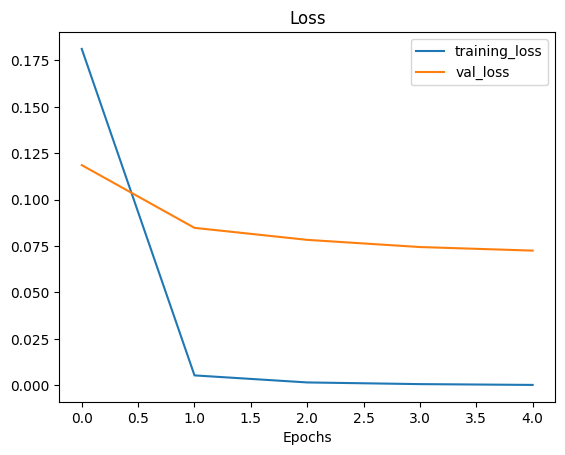

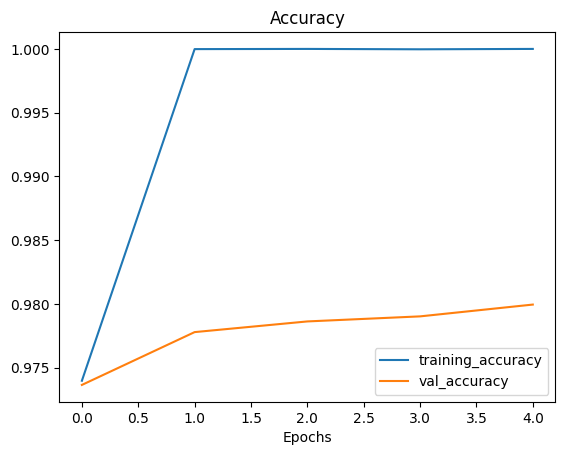

In [63]:
plot_loss_curves(resnet_history)

In [64]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 131)               268419    
                                                                 
Total params: 23,833,219
Trainable params: 268,419
Non-trainable params: 23,564,800
_________________________________________________________________


<h3 style="color:#FF7C00  "> EfficientNetB0 model </h3>

In [67]:
## Create model using EfficientNetB0 TensorFlow Hub URL (basically a CNN)
efficientnet_model = create_my_model(model_url=efficientnet_url, 
                                    num_classes=train_data_10_percent.num_classes)

### Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,                    # only use 10% of training data
                                            epochs=5,                                   # train for 5 epochs
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                            experiment_name="efficientnetB0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230707-151907
Epoch 1/5
2116/2116 [==============================] - 200s 90ms/step - loss: 0.2720 - accuracy: 0.9674 - val_loss: 0.1278 - val_accuracy: 0.9767
Epoch 2/5
2116/2116 [==============================] - 193s 91ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9835
Epoch 3/5
2116/2116 [==============================] - 190s 90ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9870
Epoch 4/5
2116/2116 [==============================] - 198s 94ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9856
Epoch 5/5
2116/2116 [==============================] - 191s 90ms/step - loss: 4.5001e-04 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 0.9887


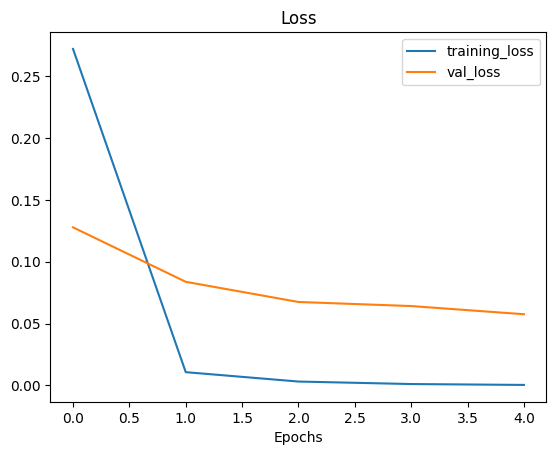

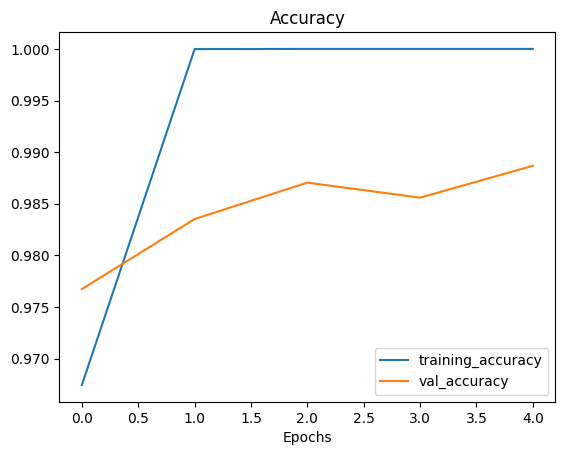

In [70]:
plot_loss_curves(efficientnet_history)

In [71]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 131)               167811    
                                                                 
Total params: 4,217,375
Trainable params: 167,811
Non-trainable params: 4,049,564
_________________________________________________________________


<h2 style="color:#FF7C00  "> Comparing models using TensorBoard </h2>

In [73]:
%%script echo skipping
## Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" --one_shot

# This will upload your TensorBoard logs to https://tensorboard.dev/ from the following director

#./tensorflow_hub/#

#This TensorBoard will be visible to everyone. Do not upload sensitive
#data.

#Your use of this service is subject to Google's Terms of Service
#<https://policies.google.com/terms> and Privacy Policy
#<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
#<https://tensorboard.dev/policy/terms/>.
#This notice will not be shown again while you are logged into the uploader.
#To log out, run `tensorboard dev auth revoke`.

#Continue? (yes/NO) yes

#To sign in with the TensorBoard uploader:

#1. On your computer or phone, visit:

#   https://www.google.com/device

#2. Sign in with your Google account, then enter:

#   GND-VDC-FRP ...
"""

2023-07-07 15:39:01.192832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   GND-VDC-FRP

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-pack

Where: <br>
--> logdir is the target upload directory   <br>
--> name is the name of the experiment   <br>
--> description is a brief description of the experiment   <br>
--> one_shot exits the TensorBoard uploader once uploading is finished   <br>

In [74]:
!tensorboard dev list

2023-07-07 15:51:12.725496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.10/dist-packa

In [75]:
!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA

2023-07-07 15:51:23.744062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Exception ignored in: <function _xla_gc_callback at 0x7f884927c5e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
KeyboardInterrupt: 

***** TensorBoard Uploader *****

This will delete the 1 experiment(s) on
https://tensorboard.dev with the following experiment ID(s):

['n6kd8XZ3Rdy1jSgSLH5WjA']

You have chosen to delete an experiment. All experiments uploaded
to TensorBoard.dev are publicly visible. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard 

In [76]:
!tensorboard dev list

2023-07-07 15:52:02.668449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Exception ignored in: <function _xla_gc_callback at 0x7f0b22d845e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last)

<h2 style="color:#FF7C00  "> <u> Example 2 </u> </h2>

In [93]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2023-07-07 16:06:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M  21.5MB/s    in 8.5s    

2023-07-07 16:06:16 (18.9 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [94]:
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10

In [95]:
""" Create data inputs. """
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical", 
                                                        batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [96]:
test_data

In [ ]:
# Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

""" If using ResNet50V2, add this to speed up convergence, remove for EfficientNet """
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

print(f"Shape after base_model: {x.shape}")
print(f"After GlobalAveragePooling2D(): {x.shape}")

In [98]:
# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

### Compile
model_0.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])
####### Train
history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_10_percent,
                                validation_steps=int(0.25 * len(test_data_10_percent)),
                                # Track our model's training logs for visualization later
                                callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230707-160658
Epoch 1/5
24/24 [==============================] - 12s 228ms/step - loss: 1.8157 - accuracy: 0.4547 - val_loss: 1.2691 - val_accuracy: 0.7385
Epoch 2/5
24/24 [==============================] - 5s 176ms/step - loss: 1.0666 - accuracy: 0.7707 - val_loss: 0.8306 - val_accuracy: 0.8322
Epoch 3/5
24/24 [==============================] - 5s 155ms/step - loss: 0.7734 - accuracy: 0.8267 - val_loss: 0.6787 - val_accuracy: 0.8553
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.6308 - accuracy: 0.8613 - val_loss: 0.6034 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.5454 - accuracy: 0.8653 - val_loss: 0.5389 - val_accuracy: 0.8734


In [99]:
""" Layers list """
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_5
1 rescaling_8
2 normalization_4
3 rescaling_9
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [100]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_8 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_4 (Normalization  (None, None, None,   7          ['rescaling_8[0][0]']            
 )                              3)                                                   

In [101]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_8 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_4 (Normalization  (None, None, None,   7          ['rescaling_8[0][0]']            
 )                              3)                                                   

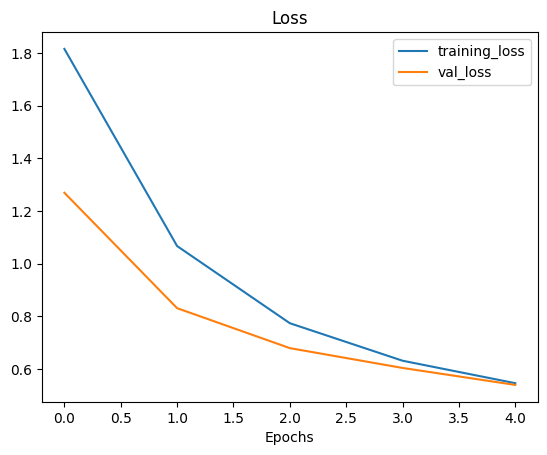

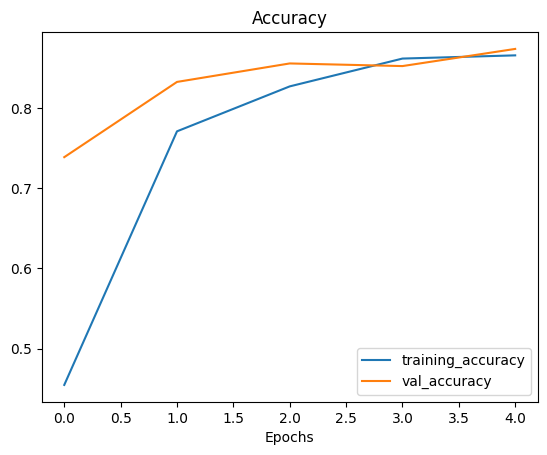

In [102]:
plot_loss_curves(history_10_percent)

In [103]:
""" Getting a feature vector from a trained model.
tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3)
"""
# Input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)
## Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")
print(f"Random input tensor:\n {input_tensor}\n")
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [104]:
""" Average across the middle axes:
Making the output of the base model compatible with the input shape requirement of the output layer (tf.keras.layers.Dense()),
it also condenses the information found by the base model into a lower dimension feature vector. 
"""
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

<div style="line-height:0.4">
<h3 style="color:#FF7C00  ">  Running a series of transfer learning experiments </h3>
<div style="line-height:1.2">

- model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.  
- model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.  
- model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.  
- model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.  
</div>
</div>

In [105]:
walk_through_dir("10_food_classes_1_percent")

In [109]:
""" Used data augmentation transformations:
    - RandomFlip - flips image on horizontal or vertical axis
    - RandomRotation - randomly rotates image by a specified amount
    - RandomZoom - randomly zooms into an image by specified amount
    - RandomHeight - randomly shifts image height by a specified amount
    - RandomWidth - randomly shifts image width by a specified amount
    - Rescaling - normalizes the image pixel values to be between 0 and 1
"""

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)   #keep for ResNet50V2, but remove for EfficientNetB0
], name ="data_augmentation")

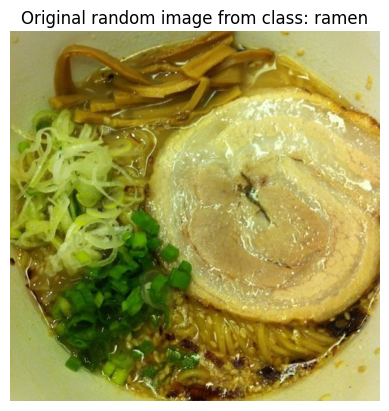

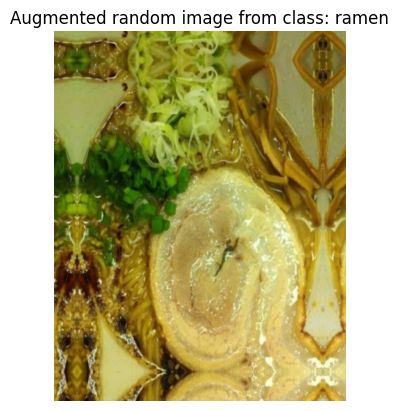

In [114]:
""" View a random image """
# Choose a random class
target_class = random.choice(train_data_10_percent.class_names)   
# Create the target directory
target_dir = "10_food_classes_10_percent/train/" + target_class   
# Choose a random image from target directory
random_image = random.choice(os.listdir(target_dir))              
# Create the choosen random image path
random_image_path = target_dir + "/" + random_image               
# Read in the chosen target image
img = mpimg.imread(random_image_path)                             
# Plot the target image
plt.imshow(img)                                                   
plt.title(f"Original random image from class: {target_class}")
# Turn off the axes
plt.axis(False);                                                  

""" Augment the image """
# Data augmentation model requires shape (None, height, width, 3)
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) 
plt.figure()
# Normalize 
plt.imshow(tf.squeeze(augmented_img)/255.) 
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

<div style="line-height:0.1">
<span style="display: inline-block;">
    <h3 style="color: #FF7C00; display: inline;"> Model # 1 </h3> <br>
    <h4> Feature extraction transfer learning on 1% of the data with data augmentation. </h4>
</div>  
</span>

In [118]:
## Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

## Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

## Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

## Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

## Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

## Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
## Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

## Compile
model_1.compile(loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])

## Fit
history_1_percent = model_1.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=int(0.25* len(test_data_10_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230707-164952
Epoch 1/5
24/24 [==============================] - 26s 611ms/step - loss: 1.9605 - accuracy: 0.3573 - val_loss: 1.3944 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - 12s 498ms/step - loss: 1.2758 - accuracy: 0.7053 - val_loss: 0.9793 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - 12s 465ms/step - loss: 0.9673 - accuracy: 0.7893 - val_loss: 0.7708 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 13s 495ms/step - loss: 0.8178 - accuracy: 0.7827 - val_loss: 0.6676 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 12s 505ms/step - loss: 0.7133 - accuracy: 0.8333 - val_loss: 0.5991 - val_accuracy: 0.8635


In [119]:
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, None)  0        
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [121]:
## Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data_10_percent)
results_1_percent_data_aug

79/79 [==============================] - 7s 75ms/step - loss: 0.6117 - accuracy: 0.8440


[0.611685037612915, 0.843999981880188]

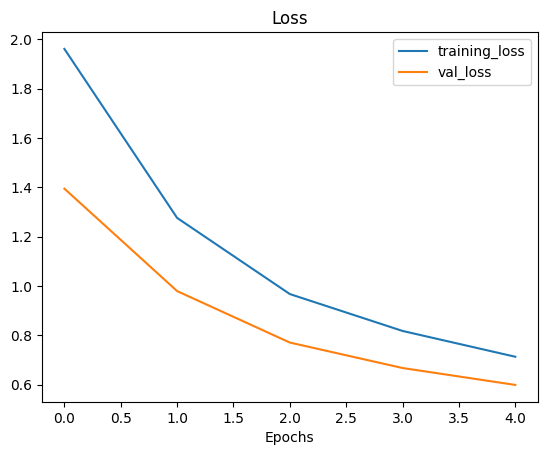

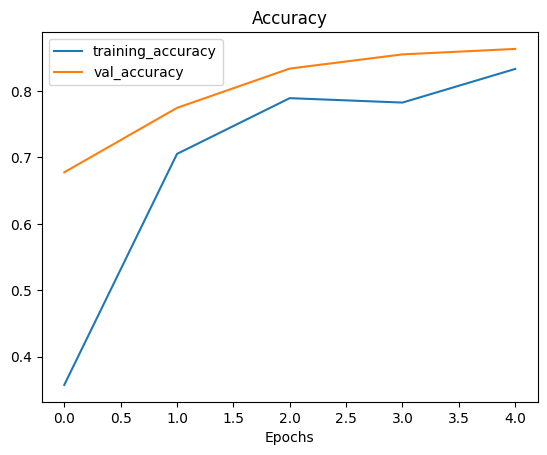

In [122]:
plot_loss_curves(history_1_percent)

<div style="line-height:0.1">
<span style="display: inline-block;">
    <h3 style="color: #FF7C00; display: inline;"> Model # 2 </h3> <br>
    <h4> Feature extraction transfer learning with 10% of data and data augmentation. </h4>
</div>  
</span>

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


In [123]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [124]:
""" Create a functional model with data augmentation """
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing      # old!!

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)       # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


# Setup the input shape to our model
input_shape = (224, 224, 3)

## Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer") 
# Augment training images
x = data_augmentation(inputs) 
# Pass augmented images to base model (keep it in inference mode, so layers don't get updated)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
                metrics=["accuracy"])


### => Creating a ModelCheckpoint callback

In [126]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" 

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,         # set to False to save the entire model
                                                        save_best_only=True,            # save only the best model weights instead of a model every epoch
                                                        save_freq="epoch",              # save every epoch
                                                        verbose=1)

In [127]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                        epochs=initial_epochs,
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                        callbacks=[
                                            create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                            checkpoint_callback
                                            ])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230707-165812
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9402 - accuracy: 0.3773
Epoch 1: val_loss improved from inf to 1.36331, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 40s 1s/step - loss: 1.9402 - accuracy: 0.3773 - val_loss: 1.3633 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2745 - accuracy: 0.6973
Epoch 2: val_loss improved from 1.36331 to 0.95176, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 408ms/step - loss: 1.2745 - accuracy: 0.6973 - val_loss: 0.9518 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9873 - accuracy: 0.7787
Epoch 3: val_loss improved from 0.95176 to 0.76428, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [====

In [128]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 83ms/step - loss: 0.6170 - accuracy: 0.8428


[0.6169589161872864, 0.8428000211715698]

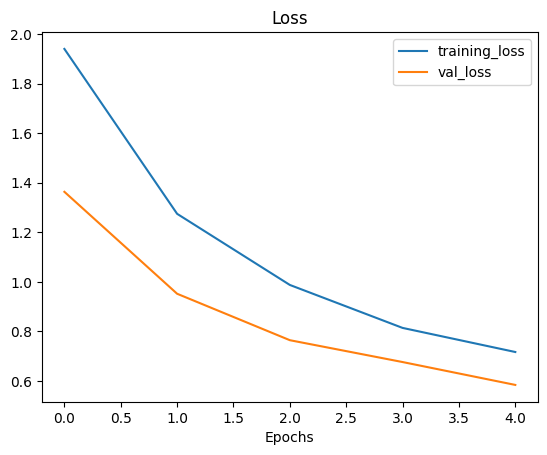

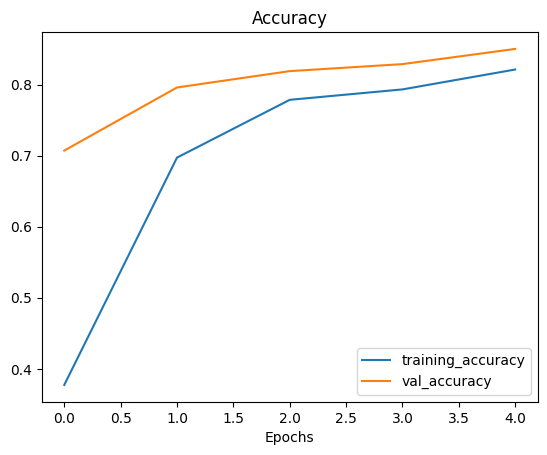

In [129]:
plot_loss_curves(history_10_percent_data_aug)

In [130]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.6170 - accuracy: 0.8428


In [133]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [134]:
# Compare loaded model results to ones of native model
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [135]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


<div style="line-height:0.1">
<h3 style="color: #FF7C00; display: inline;"> Model # 3 </h3> 
<h4> Fine-tuning an existing model on 10% of the data. </h4>
</div>  

In [136]:
model_2.layers

In [137]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [138]:
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [139]:
print(len(model_2.layers[2].trainable_variables))

0


In [140]:
print(len(base_model.trainable_variables))

0


In [141]:
## Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_11 False
1 rescaling_20 False
2 normalization_10 False
3 rescaling_21 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [142]:
base_model.trainable = True

## Freeze all layers except for the
for layer in base_model.layers[:-10]:
    layer.trainable = False

### Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),           # lr is 10x lower than before for fine-tuning
            metrics=["accuracy"])

In [143]:
## Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_11 False
1 rescaling_20 False
2 normalization_10 False
3 rescaling_21 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [144]:
print(len(model_2.trainable_variables))

12


In [145]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

####### Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                epochs=fine_tune_epochs,
                                validation_data=test_data,
                                initial_epoch=history_10_percent_data_aug.epoch[-1],            # start from previous last epoch
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) 

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230707-170510
Epoch 5/10
24/24 [==============================] - 27s 523ms/step - loss: 0.5861 - accuracy: 0.8520 - val_loss: 0.4492 - val_accuracy: 0.8569
Epoch 6/10
24/24 [==============================] - 9s 374ms/step - loss: 0.5105 - accuracy: 0.8480 - val_loss: 0.4248 - val_accuracy: 0.8618
Epoch 7/10
24/24 [==============================] - 10s 384ms/step - loss: 0.4239 - accuracy: 0.8813 - val_loss: 0.4172 - val_accuracy: 0.8569
Epoch 8/10
24/24 [==============================] - 10s 396ms/step - loss: 0.3656 - accuracy: 0.8947 - val_loss: 0.4281 - val_accuracy: 0.8470
Epoch 9/10
24/24 [==============================] - 9s 353ms/step - loss: 0.3617 - accuracy: 0.9013 - val_loss: 0.3881 - val_accuracy: 0.8651
Epoch 10/10
24/24 [==============================] - 9s 365ms/step - loss: 0.3267 - accuracy: 0.9027 - val_loss: 0.3829 - val_accuracy: 0.8586


In [146]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.4167 - accuracy: 0.8636


In [147]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """ Compares two model history objects. """
    ## Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    ## Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    # Reshift plot around epochs
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    # Reshift plot around epochs
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    
    plt.show()

5
11
[0.3773333430290222, 0.6973333358764648, 0.7786666750907898, 0.7933333516120911, 0.8213333487510681, 0.8519999980926514, 0.8479999899864197, 0.8813333511352539, 0.8946666717529297, 0.9013333320617676, 0.9026666879653931]


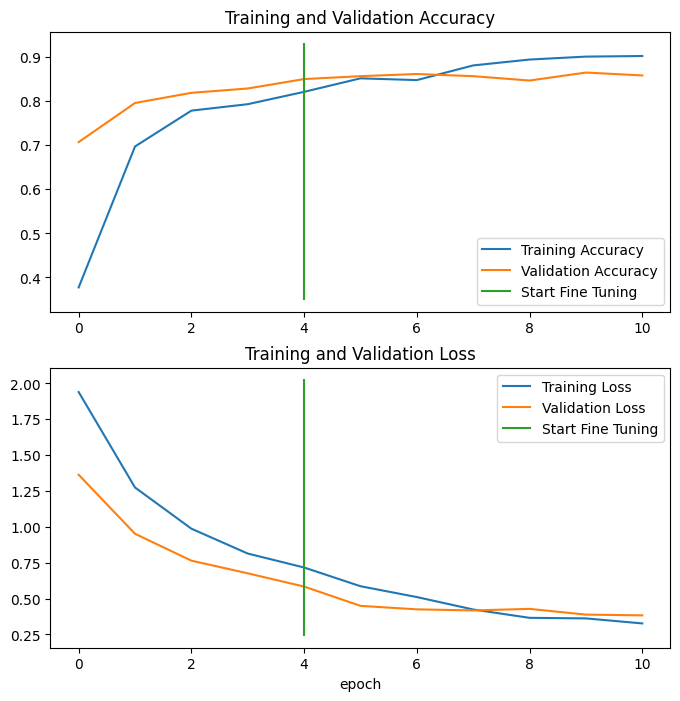

In [148]:
compare_historys(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_percent_data_aug,
                initial_epochs=5)

<div style="line-height:0.1">
<h3 style="color: #FF7C00; display: inline;"> Model # 4 </h3> 
<h4> Fine-tuning an existing model all of the data. </h4>
</div>  

In [150]:
## Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-07-07 17:07:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  24.0MB/s    in 22s     

2023-07-07 17:07:28 (22.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [151]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.

In [152]:
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            label_mode="categorical",
                                                            image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                            label_mode="categorical",
                                                            image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [153]:
""" Evaluate model (this is the fine-tuned 10 percent of data version) """
model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.4167 - accuracy: 0.8636


[0.41669151186943054, 0.8636000156402588]

In [154]:
results_fine_tune_10_percent

[0.41669151186943054, 0.8636000156402588]

In [155]:
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [161]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [163]:
"""
N.B. 
# model_2.load_weights(latest_weights) 
Revert model back to saved weights, does not work with TensorFlow 2.9.0
"""
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
checkpoint_dir = "ten_percent_model_checkpoints_weights"

latest_weights = tf.train.latest_checkpoint(checkpoint_dir)

In [164]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6170 - accuracy: 0.8428


[0.6169589161872864, 0.8428000211715698]

In [165]:
results_10_percent_data_aug

[0.6169589161872864, 0.8428000211715698]

In [166]:
## Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [167]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_11 False
1 rescaling_20 False
2 normalization_10 False
3 rescaling_21 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [168]:
""" Compile """
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [169]:
""" Continue to train and fine-tune the model to our data. """
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                            epochs=fine_tune_epochs,
                            initial_epoch=history_10_percent_data_aug.epoch[-1],
                            validation_data=test_data,
                            validation_steps=int(0.25 * len(test_data)),
                            callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230707-172405
Epoch 5/10
235/235 [==============================] - 73s 269ms/step - loss: 0.6496 - accuracy: 0.7911 - val_loss: 0.3443 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 57s 243ms/step - loss: 0.5213 - accuracy: 0.8312 - val_loss: 0.2952 - val_accuracy: 0.8997
Epoch 7/10
235/235 [==============================] - 52s 220ms/step - loss: 0.4539 - accuracy: 0.8537 - val_loss: 0.2791 - val_accuracy: 0.9095
Epoch 8/10
235/235 [==============================] - 46s 194ms/step - loss: 0.4168 - accuracy: 0.8647 - val_loss: 0.2799 - val_accuracy: 0.9178
Epoch 9/10
235/235 [==============================] - 45s 188ms/step - loss: 0.3788 - accuracy: 0.8771 - val_loss: 0.2660 - val_accuracy: 0.9194
Epoch 10/10
235/235 [==============================] - 44s 184ms/step - loss: 0.3434 - accuracy: 0.8897 - val_loss: 0.2503 - val_accuracy: 0.9326


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)